# Import and dataset load


In [1]:
import numpy as np
import pandas as pd
from itertools import product

import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
sns.color_palette("pastel")

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("deposit.csv", sep=";")
data["Date"] = pd.to_datetime(data["Date"], format="%d.%m.%Y")
data.set_index("Date", inplace=True)
data["Deposit_rub"] = (
    data["Deposit_rub"].apply(lambda x: x.replace(",", ".")).astype(float)
)
# data["Deposit_currency"] = (
#     data["Deposit_currency"].apply(lambda x: x.replace(",", ".")).astype(float)
# )

In [4]:
data

,Deposit_rub,Deposit_currency,Inflation
Date,,,
2014-01-01,14000569.00,"2956962,00","0,34"
2014-02-01,13433121.00,"3256299,00","0,59"
2014-03-01,13510318.00,"3397706,00","0,99"
2014-04-01,13206977.00,"3356873,00","0,88"
2014-05-01,13507416.00,"3340055,00","0,94"
...,...,...,...
2020-08-01,25534027.52,"6573805,47","0,40"
2020-09-01,25557608.90,"6657799,00","0,25"
2020-10-01,25699001.52,"7006929,19","0,48"


# Data analysis

Text(0.5, 0, 'Months')

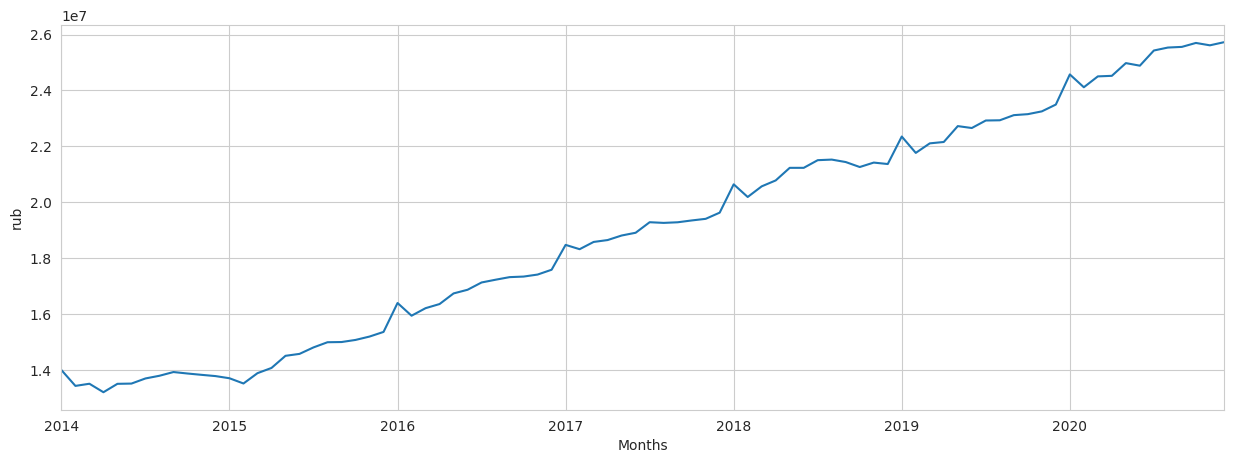

In [5]:
plt.figure(figsize=(15, 5))
data.Deposit_rub.plot()
plt.ylabel("rub")
plt.xlabel("Months")

In [59]:
# evaluate components of time-series
# evaluate Dickey-Fuller test for time-series stationarity
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(data.Deposit_rub)[1])

Dickey-Fuller test: p=0.914995


<Figure size 2000x500 with 0 Axes>

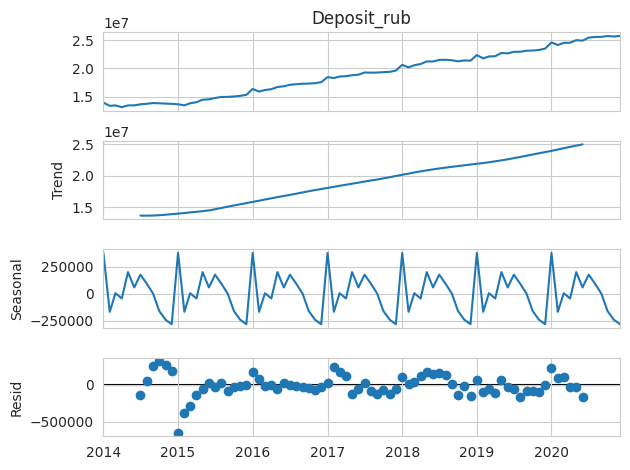

In [6]:
plt.figure(figsize=(20, 5))
sm.tsa.seasonal_decompose(data.Deposit_rub).plot()
plt.show()

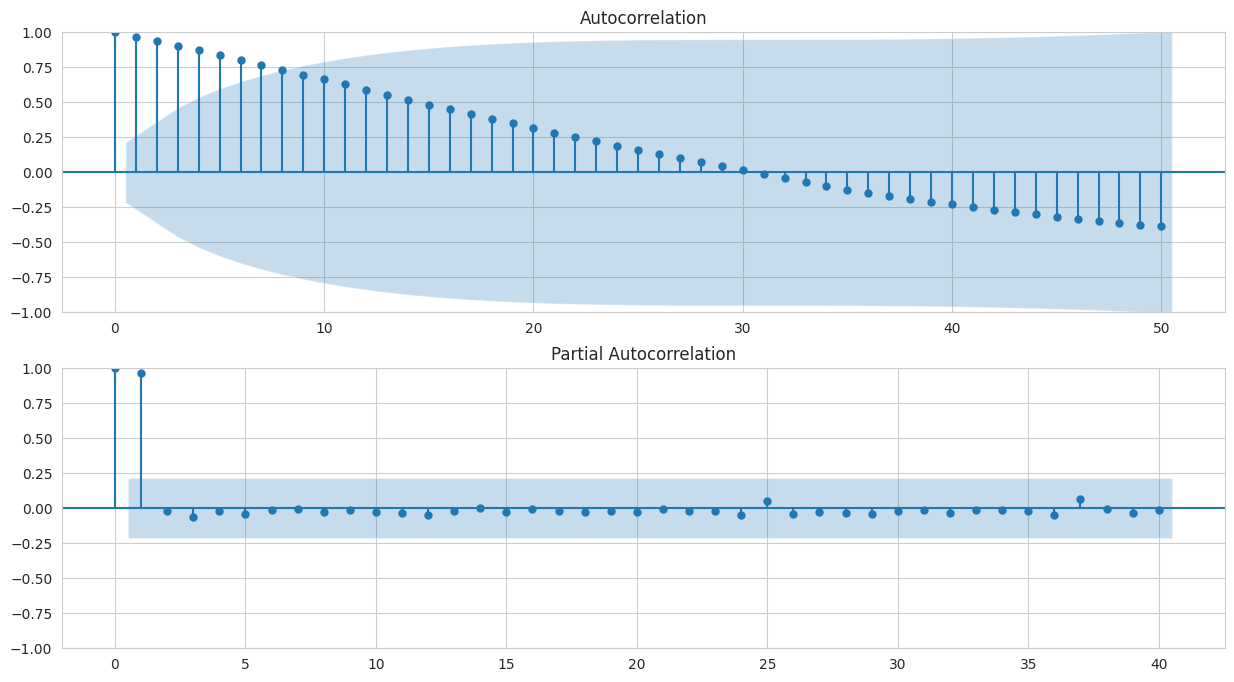

In [7]:
# let's calculate autocorrelation and partial autocorrelation components

plt.figure(figsize=(15, 8))

# autocorrelation
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.Deposit_rub.values.squeeze(), lags=50, ax=ax)

# partial autocorrelation
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.Deposit_rub.values.squeeze(), lags=40, ax=ax)
plt.show()

Best Box-Cox parameter: 0.408737
Dickey-Fuller test: p=0.368960


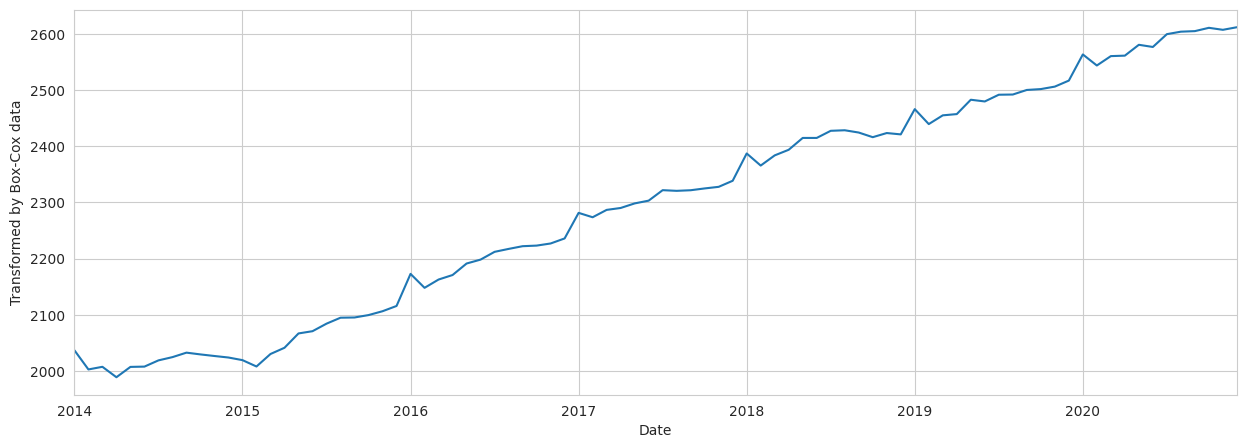

In [9]:
# Box-Cox transformation for dispersion stationarity

data["deposit_rub_box"], lmbda = stats.boxcox(data.Deposit_rub)
plt.figure(figsize=(15, 5))
data.deposit_rub_box.plot()
plt.ylabel("Transformed by Box-Cox data")
print("Best Box-Cox parameter: %f" % lmbda)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(data.deposit_rub_box)[1])

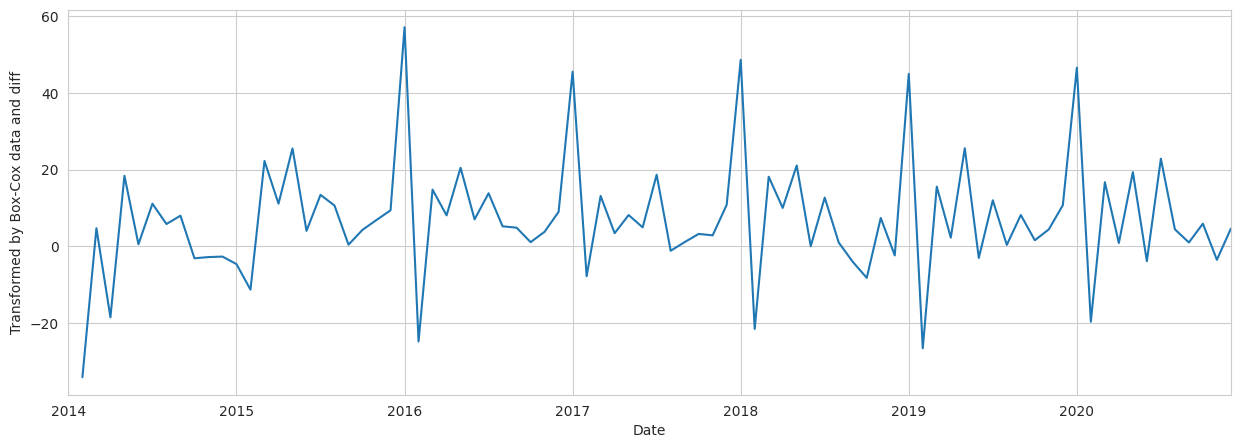

Dickey-Fuller test: p=0.004385


In [10]:
# difference for 1 months

data["deposit_rub_box_diff"] = data.deposit_rub_box - data.deposit_rub_box.shift(1)
plt.subplots(figsize=(15, 5))
data.deposit_rub_box_diff.plot()
plt.ylabel("Transformed by Box-Cox data and diff")
plt.show()
print(
    "Dickey-Fuller test: p=%f"
    % sm.tsa.stattools.adfuller(data.deposit_rub_box_diff[1:])[1]
)

# Sarima no finetuning

In [34]:
train = data.deposit_rub_box[:int(len(data)*0.8)]
test = data.deposit_rub_box[int(len(data)*0.8):]

In [60]:
p, d, q = 3, 1, 4
P, D, Q, s = 2, 1, 3, 12


model = sm.tsa.SARIMAX(
    train,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()

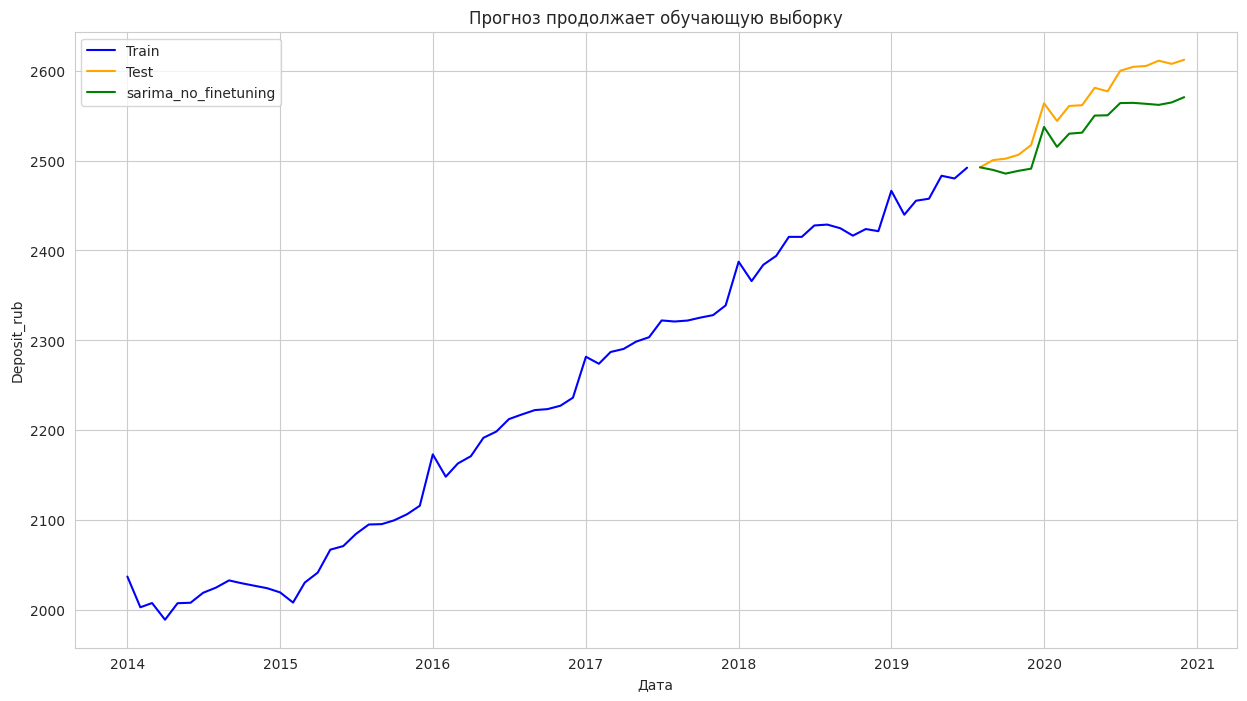

In [61]:
forecast_no_train = results.forecast(steps=len(test))
# Построение графиков
plt.figure(figsize=(15, 8))

# Добавляем обучающую выборку
plt.plot(train.index, train, label="Train", color="blue")

# Добавляем тестовую выборку
plt.plot(test.index, test, label="Test", color="orange")

# Добавляем прогноз
plt.plot(test.index, forecast_no_train, label="sarima_no_finetuning", color="green")

# Оформляем график
plt.legend()
plt.title("Прогноз продолжает обучающую выборку")
plt.xlabel("Дата")
plt.ylabel("Deposit_rub")
plt.grid(True)
plt.show()


In [67]:
# Получаем остатки модели
residuals = results.resid

from statsmodels.stats.diagnostic import acorr_ljungbox

# Тест Ljung-Box для остатков
ljung_box_test = acorr_ljungbox(residuals, lags=40)
print(ljung_box_test)

      lb_stat  lb_pvalue
1    1.343659   0.246390
2    3.388444   0.183742
3    5.847050   0.119293
4    5.909825   0.205985
5    6.016901   0.304578
6    6.016904   0.421299
7    6.063283   0.532380
8    6.078930   0.638391
9    6.370821   0.702307
10   6.675123   0.755718
11   6.922675   0.805310
12  25.373008   0.013151
13  26.314362   0.015422
14  27.465787   0.016736
15  30.115778   0.011511
16  30.116012   0.017410
17  30.118272   0.025505
18  30.123225   0.036266
19  30.125915   0.050218
20  30.125965   0.067838
21  30.169455   0.088635
22  30.189417   0.113933
23  30.259127   0.142107
24  31.863795   0.130406
25  31.890093   0.161217
26  32.089685   0.190173
27  32.307665   0.220881
28  32.320104   0.261681
29  32.320139   0.305998
30  32.320565   0.352770
31  32.320696   0.401331
32  32.320940   0.450907
33  32.324566   0.500557
34  32.350121   0.548599
35  32.350125   0.596689
36  34.124067   0.558050
37  34.250955   0.598614
38  34.510047   0.631609
39  35.125412   0.647257


Модель является адекватной до 12 лага p-value > 0.05

# Sarima with finetuning

In [68]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Определяем диапазоны параметров
p = q = range(0, 4)  # Параметры AR и MA
d = 1  # Параметр дифференцирования
P = Q = range(0, 3)  # Сезонные параметры
D = 1  # Сезонное дифференцирование
s = range(3, 13, 3)  # Период сезонности (3, 6, 9, 12)

# Перебор всех комбинаций параметров
pdq = list(itertools.product(p, q))
seasonal_pdq = list(itertools.product(P, Q, [D], s))

best_aic = float("inf")
best_params = None
best_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(
                train,
                order=(param[0], d, param[1]),
                seasonal_order=(param_seasonal[0], param_seasonal[2], param_seasonal[1], param_seasonal[3]),
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            results = model.fit(disp=False)

            if results.aic < best_aic:  # Минимизируем AIC
                best_aic = results.aic
                best_params = (param, param_seasonal)
                best_model = results
        except Exception as e:
            continue

print(f"Лучшие параметры: ARIMA{best_params[0]} x Seasonal{best_params[1]} (AIC={best_aic})")


Лучшие параметры: ARIMA(1, 3) x Seasonal(2, 2, 1, 12) (AIC=166.54995532408614)


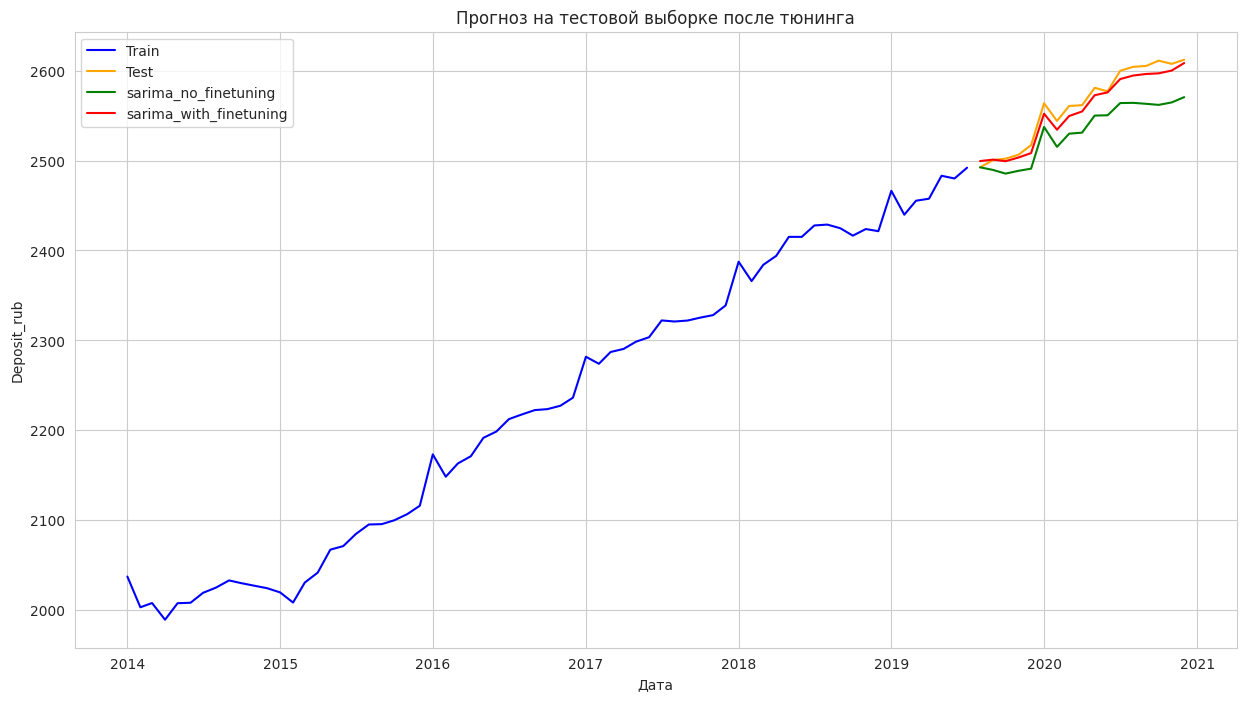

In [69]:
# Прогноз на тестовой выборке
forecast_with_train = best_model.forecast(steps=len(test))

# Визуализация
plt.figure(figsize=(15, 8))
plt.plot(train.index, train, label="Train", color="blue")
plt.plot(test.index, test, label="Test", color="orange")
plt.plot(test.index, forecast_no_train, label="sarima_no_finetuning", color="green")
plt.plot(test.index, forecast_with_train, label="sarima_with_finetuning", color="red")
plt.legend()
plt.title("Прогноз на тестовой выборке после тюнинга")
plt.xlabel("Дата")
plt.ylabel("Deposit_rub")
plt.grid(True)
plt.show()


In [70]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Получаем остатки модели
residuals = best_model.resid

# Выполняем тест Ljung-Box для остатков
lb_test = acorr_ljungbox(residuals, lags=12, return_df=True)

# Выводим результат
print(lb_test)

      lb_stat  lb_pvalue
1    4.357015   0.036857
2    4.419171   0.109746
3    4.450699   0.216730
4    4.455595   0.347845
5    4.455822   0.485816
6    4.456305   0.615175
7    4.456633   0.725933
8    4.457118   0.813708
9    4.459096   0.878687
10   4.464447   0.923973
11   4.604003   0.948820
12  11.407584   0.494349


Модель является адекватной (p-value > 0.05) на всех значениях лагов кроме лаг = 1, но это не критично, так как на 2-ом лаге уже p-value значительно больше 0.05

In [77]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

rmse = mean_squared_error(test, forecast_with_train, squared=False)
mape = mean_absolute_percentage_error(test, forecast_with_train)

print(f"RMSE на тестовой выборке: {rmse:.2f}")
print(f"MAPE на тестовой выборке: {mape:.2%}")

RMSE на тестовой выборке: 8.21
MAPE на тестовой выборке: 0.28%


# Holt-Winters

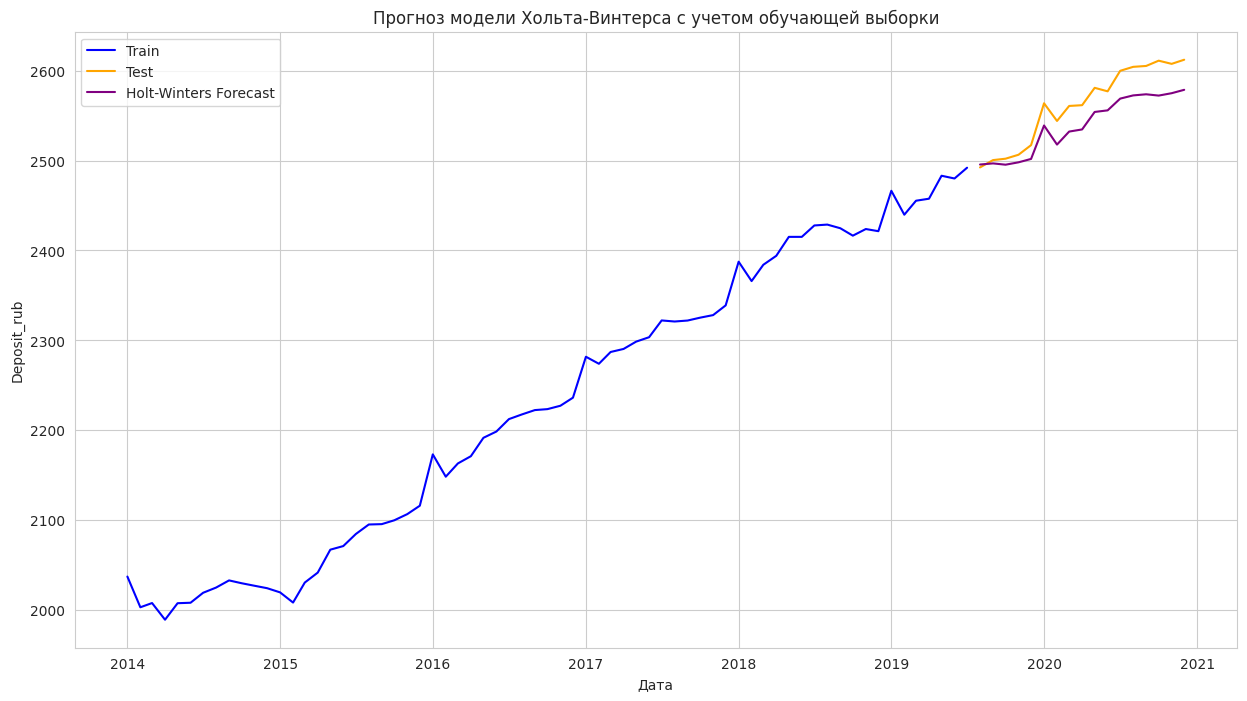

In [78]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Обучение модели Хольта-Винтерса
hw_model = ExponentialSmoothing(
    train,
    trend="add",
    seasonal='add',
    seasonal_periods=12
).fit()

# Прогноз на тестовые данные
hw_forecast = hw_model.forecast(len(test))

# Построение графика
plt.figure(figsize=(15, 8))

# Добавляем обучающую выборку
plt.plot(train.index, train, label="Train", color="blue")

# Добавляем тестовую выборку
plt.plot(test.index, test, label="Test", color="orange")

# Добавляем прогноз
plt.plot(test.index, hw_forecast, label="Holt-Winters Forecast", color="purple")

# Оформление графика
plt.legend()
plt.title("Прогноз модели Хольта-Винтерса с учетом обучающей выборки")
plt.xlabel("Дата")
plt.ylabel("Deposit_rub")
plt.grid(True)
plt.show()


In [79]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

rmse = mean_squared_error(test, hw_forecast, squared=False)
mape = mean_absolute_percentage_error(test, hw_forecast)

print(f"RMSE на тестовой выборке: {rmse:.2f}")
print(f"MAPE на тестовой выборке: {mape:.2%}")

RMSE на тестовой выборке: 25.51
MAPE на тестовой выборке: 0.89%


In [80]:
residuals = hw_model.resid

# Выполняем тест Ljung-Box для остатков
lb_test = acorr_ljungbox(residuals, lags=12, return_df=True)

# Выводим результат
print(lb_test)

      lb_stat  lb_pvalue
1    0.098164   0.754044
2    0.271160   0.873209
3    0.638613   0.887539
4    2.794664   0.592754
5    3.206436   0.668194
6    3.316942   0.768144
7    3.925613   0.788304
8    4.285167   0.830522
9    8.123359   0.521764
10   8.577999   0.572565
11   8.730485   0.646754
12  12.488225   0.407308


Модель является адекватной (p-value > 0.05)

# Result graphic

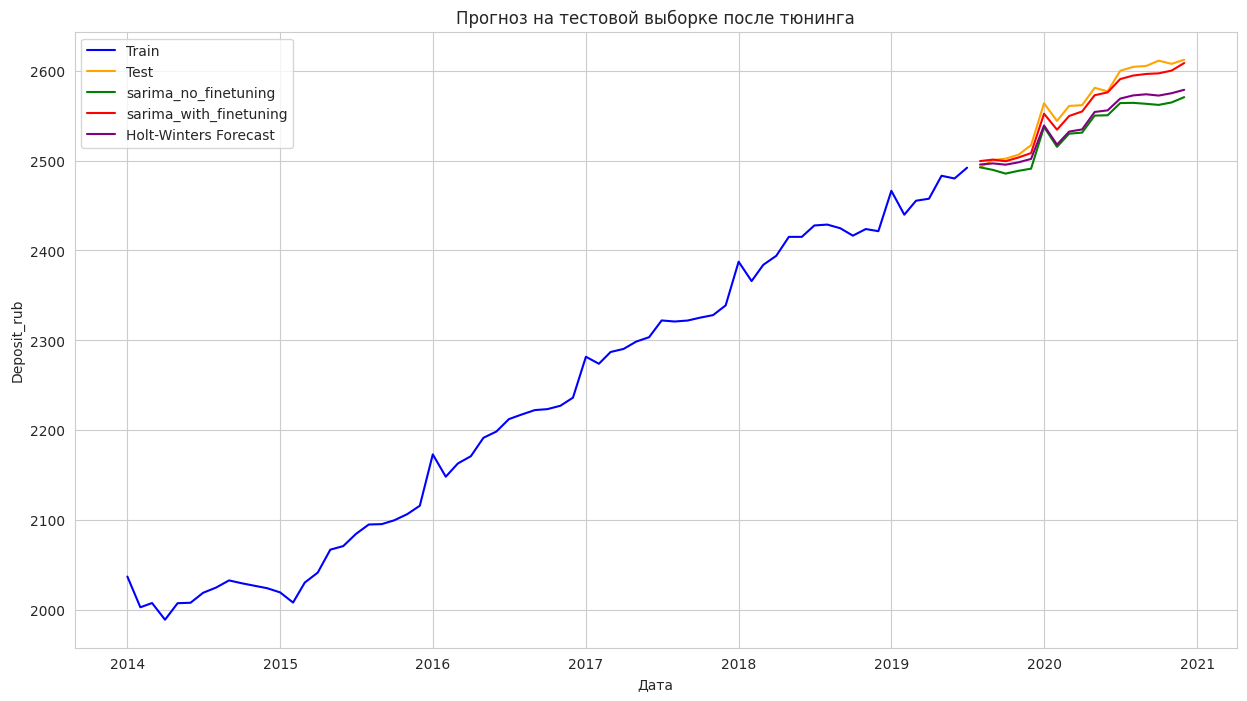

In [81]:
# Визуализация
plt.figure(figsize=(15, 8))
plt.plot(train.index, train, label="Train", color="blue")
plt.plot(test.index, test, label="Test", color="orange")
plt.plot(test.index, forecast_no_train, label="sarima_no_finetuning", color="green")
plt.plot(test.index, forecast_with_train, label="sarima_with_finetuning", color="red")
plt.plot(test.index, hw_forecast, label="Holt-Winters Forecast", color="purple")
plt.legend()
plt.title("Прогноз на тестовой выборке после тюнинга")
plt.xlabel("Дата")
plt.ylabel("Deposit_rub")
plt.grid(True)
plt.show()